# Lung and Colon Cancer Classification

### Importing the packages

In [ ]:
!pip install vit-keras==0.1.2
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Importing the liabraries
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input,Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, MobileNetV3Large
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm
from vit_keras import vit
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay
import os
import pandas as pd

# if you dont have cuda enabled gpu in your system comment the lines below
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### unzip the dataset

# Define the path to the ZIP file and the target directory for extraction
zip_file_path = '/content/drive/MyDrive/dataset/data_set.zip'
extracted_folder_path = '/content/drive/MyDrive/dataset/'

# Use the ! command to unzip the file
!unzip "$zip_file_path" -d "$extracted_folder_path"


Archive:  /content/drive/MyDrive/dataset/data_set.zip
replace /content/drive/MyDrive/dataset/data_set/colon_image_sets/colon_aca/colonca2010.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Load the dataset

In [ ]:
# loading the datas
images = []
labels = []
# Location with subdirectories
path = "/content/drive/MyDrive/dataset/data_set"
# Get List of all images
files = glob.glob(path + '/**/*.jpeg', recursive=True)
# For each image
for file in  tqdm (files):
    img = cv2.imread(file)[:,:,::-1]
    img = cv2.resize(img,(224,224))
    #print(file)
    images.append(img)
    y = file.split('/')[-2]
    #print(y)
    labels.append(y)
images = np.array(images)
labels = np.array(labels)

100%|██████████| 15000/15000 [47:49<00:00,  5.23it/s]


### Data Analysis




In [ ]:
# shape of images
print("Shape of Data = ", images.shape)

Shape of Data =  (15000, 224, 224, 3)


In [ ]:
print("Shape of labels = ", labels.shape)

Shape of labels =  (15000,)


lung_aca     3000
lung_n       3000
lung_scc     3000
colon_n      3000
colon_aca    3000
Name: labels, dtype: int64


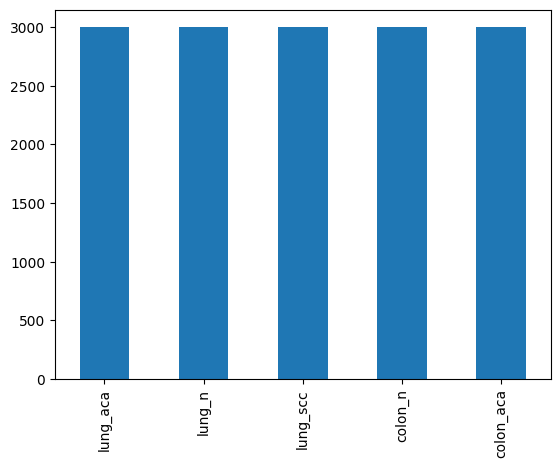

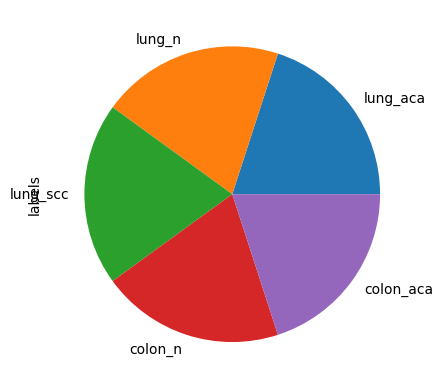

In [ ]:
# storing the labels in the data frame
labels_df = pd.DataFrame(labels,columns=['labels'])

print(labels_df['labels'].value_counts())
plt.figure()
labels_df['labels'].value_counts().plot.bar()
plt.show()
plt.figure()
labels_df['labels'].value_counts().plot.pie()
plt.show()

In [ ]:
# This code will help you in visualizing mages
#np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(str(labels[index]))
    plt.imshow(images[index])
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# loabel encoding of categorical features
le = LabelEncoder()
labels = le.fit_transform(labels)

# one hot encoding to feed it into model.
labels =to_categorical(labels)


In [ ]:
#### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


### Deep Learning Models

In [ ]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();

accuracy_loss_plot = PlotLearning()

### Model 1 MobileNet

In [ ]:
### initializing the model
base_model = MobileNetV3Large(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])
model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 960)              3840      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

In [ ]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= 0.001), metrics=['accuracy'])

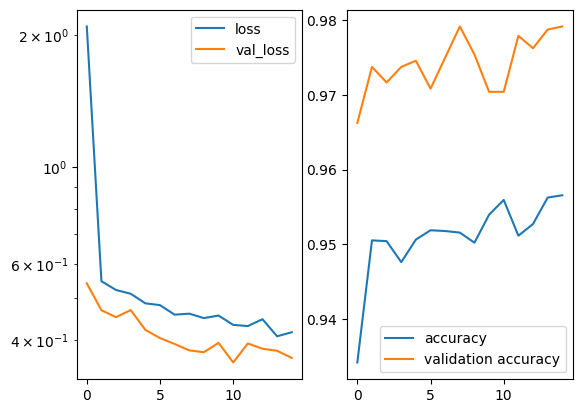

600/600 [==============================] - 54s 90ms/step - loss: 0.4175 - accuracy: 0.9566 - val_loss: 0.3647 - val_accuracy: 0.9792


In [ ]:
#train the model with min batch size as 32
history=model.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=16, callbacks=accuracy_loss_plot)

#### Model Evaluation

In [ ]:
#### train performace

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

750/750 [==============================] - 56s 74ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2408
           1       1.00      1.00      1.00      2401
           2       0.96      0.96      0.96      2401
           3       1.00      1.00      1.00      2364
           4       0.96      0.96      0.96      2426

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



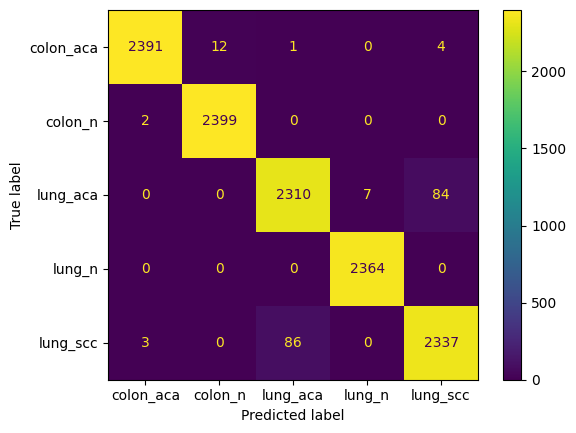

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
#### test performance

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


188/188 [==============================] - 14s 71ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       592
           1       1.00      1.00      1.00       599
           2       0.95      0.94      0.95       599
           3       0.99      1.00      1.00       636
           4       0.95      0.95      0.95       574

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



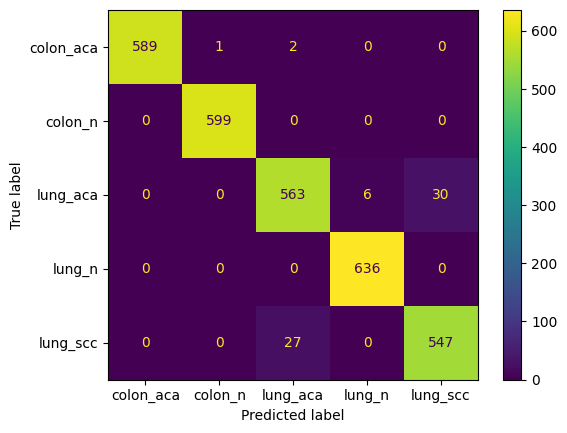

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

### Model 2 VGG 16

In [ ]:
### initializing the model
base_model = VGG16(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,849,349
Trainable params: 133,637
Non-

In [ ]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

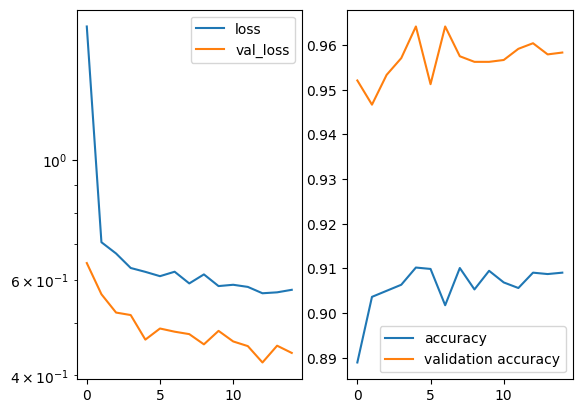

1200/1200 [==============================] - 390s 325ms/step - loss: 0.5758 - accuracy: 0.9091 - val_loss: 0.4402 - val_accuracy: 0.9583


In [ ]:
history=model.fit(X_train,y_train,batch_size=8,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [ ]:
### train performance

In [ ]:
y_pred = model.predict(X_train,batch_size=15)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

800/800 [==============================] - 395s 494ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2408
           1       1.00      0.98      0.99      2401
           2       0.92      0.94      0.93      2401
           3       0.99      1.00      0.99      2364
           4       0.95      0.93      0.94      2426

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



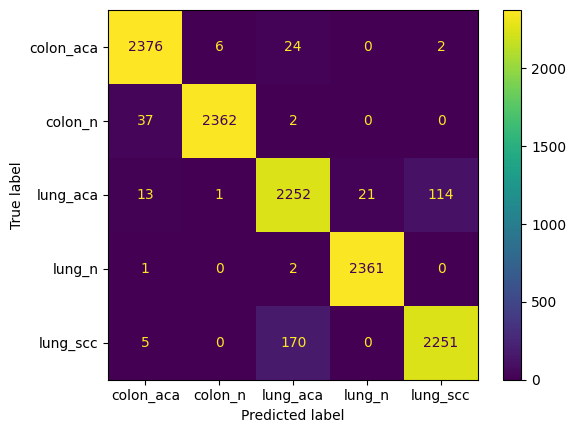

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
### test performace

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=15)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


200/200 [==============================] - 98s 491ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       592
           1       1.00      0.98      0.99       599
           2       0.92      0.92      0.92       599
           3       0.98      1.00      0.99       636
           4       0.94      0.92      0.93       574

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



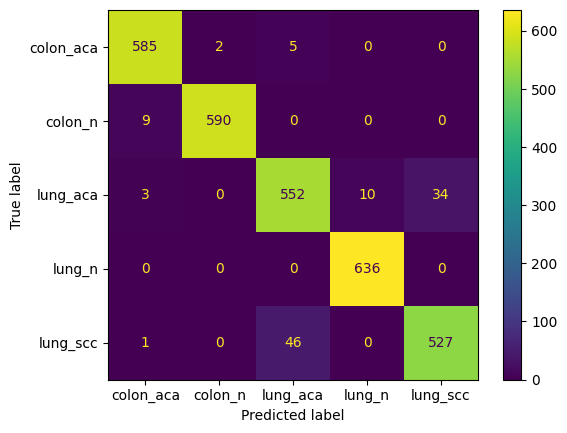

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

### Model 3 ResNet 50

In [ ]:
### initializing the model
base_model = ResNet50(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,121,733
Trainable params: 529,925
Non-

In [ ]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

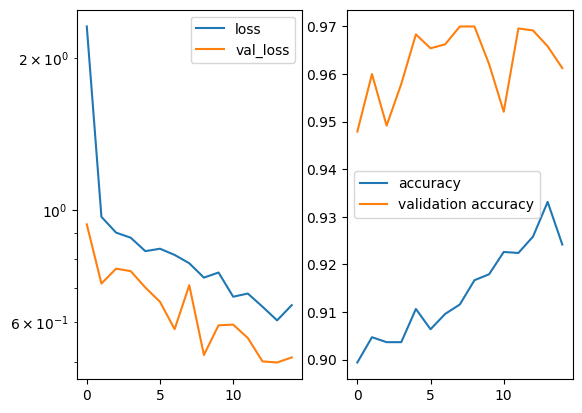

1200/1200 [==============================] - 170s 142ms/step - loss: 0.6469 - accuracy: 0.9242 - val_loss: 0.5097 - val_accuracy: 0.9613


In [ ]:
history=model.fit(X_train,y_train,batch_size=8,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [ ]:
### train performance

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

750/750 [==============================] - 188s 249ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2408
           1       0.99      1.00      0.99      2401
           2       0.89      0.98      0.93      2401
           3       1.00      1.00      1.00      2364
           4       0.98      0.88      0.93      2426

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



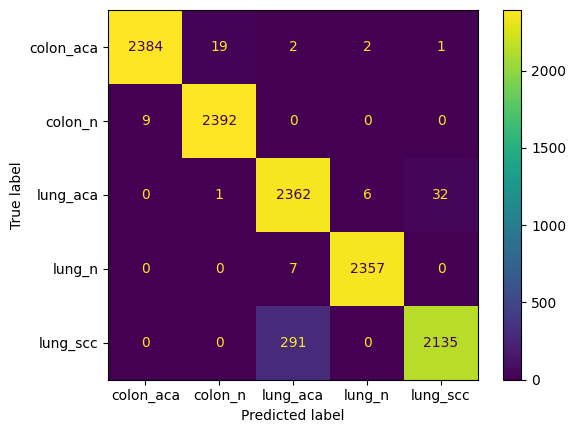

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
### test performace

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


188/188 [==============================] - 47s 243ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       592
           1       1.00      1.00      1.00       599
           2       0.89      0.98      0.94       599
           3       1.00      0.99      1.00       636
           4       0.98      0.89      0.93       574

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



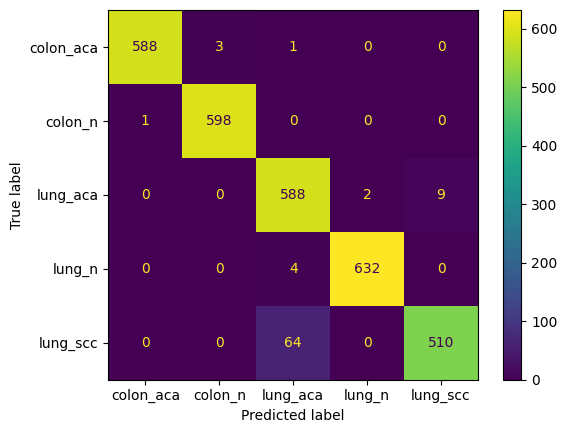

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

### Vision Transformer B16

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)
vit_model.trainable=False

347502902/347502902 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
        vit_model,
        Flatten(),
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               196864    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= 0.001), metrics=['accuracy'])

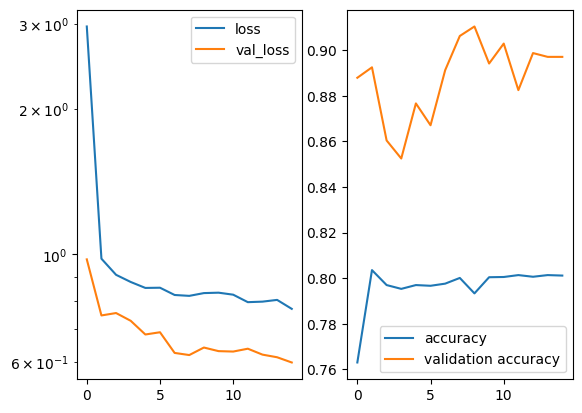

600/600 [==============================] - 871s 1s/step - loss: 0.7717 - accuracy: 0.8011 - val_loss: 0.5976 - val_accuracy: 0.8971


In [ ]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=16, callbacks=accuracy_loss_plot)

In [ ]:
### Train Performance

In [ ]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

750/750 [==============================] - 826s 1s/step


              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2408
           1       0.81      0.98      0.89      2401
           2       0.86      0.85      0.86      2401
           3       0.98      0.96      0.97      2364
           4       0.88      0.90      0.89      2426

    accuracy                           0.89     12000
   macro avg       0.90      0.89      0.89     12000
weighted avg       0.90      0.89      0.89     12000



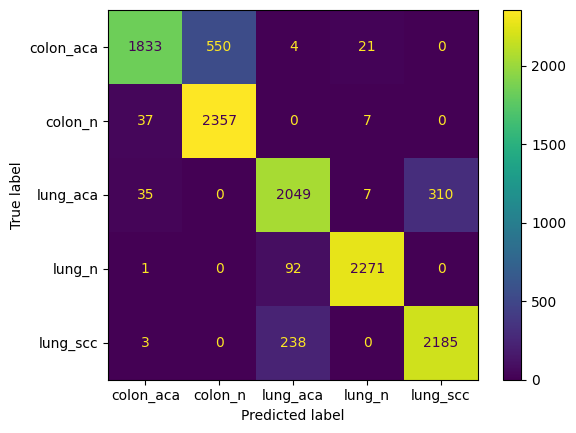

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
#### Test Perfornmance

In [ ]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


188/188 [==============================] - 203s 1s/step


              precision    recall  f1-score   support

           0       0.97      0.74      0.84       592
           1       0.80      0.99      0.89       599
           2       0.87      0.86      0.87       599
           3       0.98      0.96      0.97       636
           4       0.88      0.91      0.90       574

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



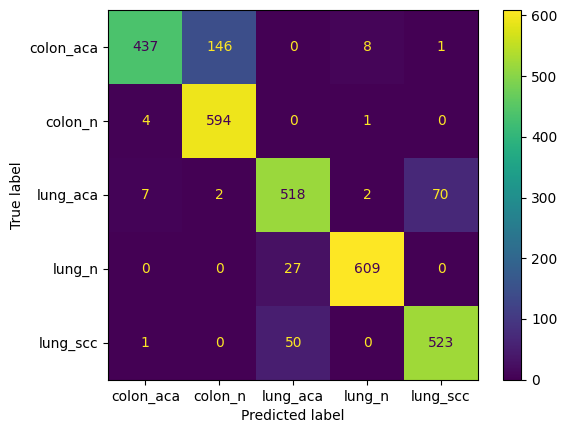

In [ ]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()